Распределение классов в y_train до балансировки:
target
0    102121
1       390
Name: count, dtype: int64
Удаляем 11 признаков из 73
Оставшиеся признаки: 62

Распределение классов после undersampling:
target
0    39000
1      390
Name: count, dtype: int64

Обучение модели...

Оптимальный порог по F1: 0.0487
Precision: 0.0870, Recall: 0.2653, F1: 0.1310

Метрики стекинг-модели с оптимальным порогом:
Accuracy: 0.9865
Precision: 0.0870
Recall: 0.2653
F1: 0.1310
ROC-AUC: 0.8648

Матрица ошибок:
[[25257   273]
 [   72    26]]


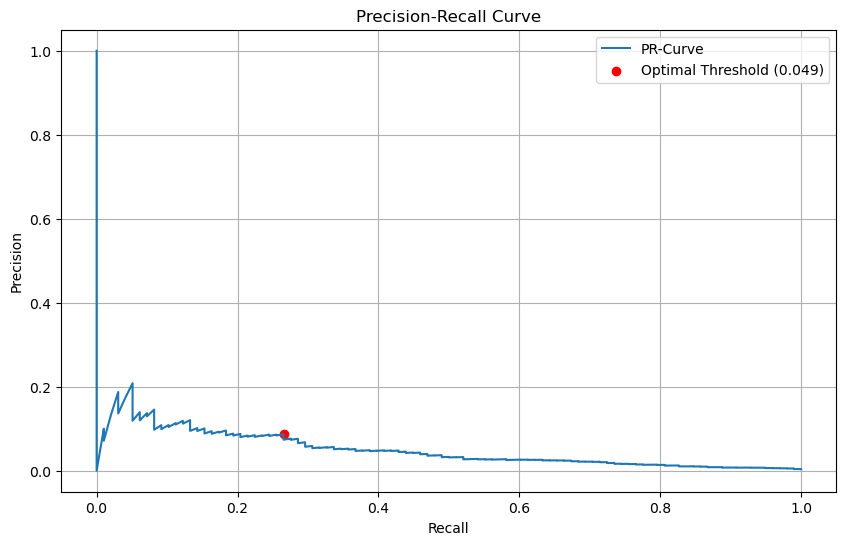

In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, confusion_matrix
from sklearn.utils import resample
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

# === 1. Загрузка данных ===
data = pd.read_csv("TrainData.csv", sep=";")
X = data.drop("target", axis=1)
y = data["target"]

# Переименуем фичи для XGBoost
X.columns = [f"f{i}" for i in range(X.shape[1])]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Распределение классов в y_train до балансировки:")
print(y_train.value_counts())

# === 1b. Удаляем бесполезные признаки ===
# 1. Низкая дисперсия
low_variance_features = X_train.columns[X_train.var() < 1e-5].tolist()

# 2. Сильно коррелирующие признаки
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [col for col in upper.columns if any(upper[col] > 0.95)]

# 3. Признаки с низкой важностью (RandomForest)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
low_importance_features = importances[importances < 0.001].index.tolist()

# Список всех признаков для удаления
features_to_drop = list(set(low_variance_features + high_corr_features + low_importance_features))
print(f"Удаляем {len(features_to_drop)} признаков из {X_train.shape[1]}")

X_train = X_train.drop(columns=features_to_drop)
X_test = X_test.drop(columns=features_to_drop, errors='ignore')

print(f"Оставшиеся признаки: {X_train.shape[1]}")

# === 2. Undersampling класса 0 ===
X_train_majority = X_train[y_train == 0]
y_train_majority = y_train[y_train == 0]

X_train_minority = X_train[y_train == 1]
y_train_minority = y_train[y_train == 1]

# Соотношение 100:1
n_majority = len(y_train_minority) * 100
X_train_majority_downsampled, y_train_majority_downsampled = resample(
    X_train_majority, y_train_majority,
    replace=False,
    n_samples=n_majority,
    random_state=42
)

X_train_balanced = pd.concat([X_train_majority_downsampled, X_train_minority])
y_train_balanced = pd.concat([y_train_majority_downsampled, y_train_minority])

print("\nРаспределение классов после undersampling:")
print(y_train_balanced.value_counts())

# === 3. Модели ===
base_models = [
    ("lr", LogisticRegression(max_iter=500, random_state=42)),
    ("rf", RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)),
    ("xgb", XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6,
                          subsample=0.8, colsample_bytree=0.8, eval_metric="logloss",
                          use_label_encoder=False, random_state=42, tree_method="auto")),
    ("lgbm", LGBMClassifier(n_estimators=300, learning_rate=0.05, max_depth=-1,
                            subsample=0.8, colsample_bytree=0.8, random_state=42))
]

meta_model = LogisticRegression(max_iter=1000, random_state=42)

stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=3,
    n_jobs=-1
)

# === 4. Обучение ===
print("\nОбучение модели...")
stack_model.fit(X_train_balanced, y_train_balanced)

# === 5. Предсказание ===
y_pred_proba = stack_model.predict_proba(X_test)[:, 1]

# === 6. Подбор оптимального порога ===
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nОптимальный порог по F1: {optimal_threshold:.4f}")
print(f"Precision: {precisions[optimal_idx]:.4f}, Recall: {recalls[optimal_idx]:.4f}, F1: {f1_scores[optimal_idx]:.4f}")

y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# === 7. Метрики ===
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_optimal),
    "Precision": precision_score(y_test, y_pred_optimal),
    "Recall": recall_score(y_test, y_pred_optimal),
    "F1": f1_score(y_test, y_pred_optimal),
    "ROC-AUC": roc_auc_score(y_test, y_pred_proba)
}

print("\nМетрики стекинг-модели с оптимальным порогом:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# === 8. Матрица ошибок ===
print("\nМатрица ошибок:")
cm = confusion_matrix(y_test, y_pred_optimal)
print(cm)

# === 9. PR-кривая ===
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, label='PR-Curve')
plt.scatter(recalls[optimal_idx], precisions[optimal_idx], c='red', label=f'Optimal Threshold ({optimal_threshold:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


Удаляем 11 признаков из 73
Оставшиеся признаки: 62

Распределение классов после undersampling:
target
0    39000
1      390
Name: count, dtype: int64
Распределение классов после SMOTE:
target
0    39000
1    39000
Name: count, dtype: int64

Обучение модели...

Выбран порог для максимального Recall: 0.0100

Метрики стекинг-модели с порогом на Recall:
Accuracy: 0.9060
Precision: 0.0223
Recall: 0.5510
F1: 0.0429
ROC-AUC: 0.8252

Матрица ошибок:
[[23166  2364]
 [   44    54]]


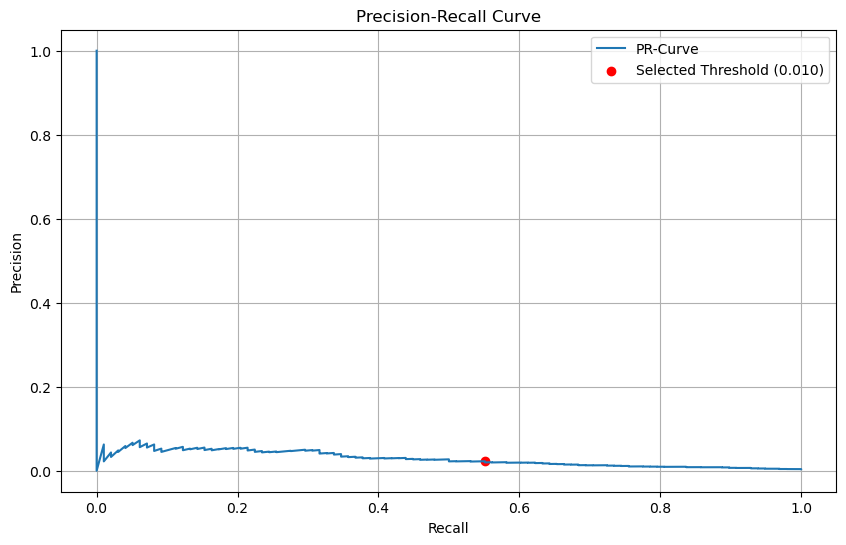

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, confusion_matrix
from sklearn.utils import resample
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# === 1. Загрузка данных ===
data = pd.read_csv("TrainData.csv", sep=";")
X = data.drop("target", axis=1)
y = data["target"]

X.columns = [f"f{i}" for i in range(X.shape[1])]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === 1b. Удаляем бесполезные признаки ===
low_variance_features = X_train.columns[X_train.var() < 1e-5].tolist()
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [col for col in upper.columns if any(upper[col] > 0.95)]
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
low_importance_features = importances[importances < 0.001].index.tolist()

features_to_drop = list(set(low_variance_features + high_corr_features + low_importance_features))
print(f"Удаляем {len(features_to_drop)} признаков из {X_train.shape[1]}")
X_train = X_train.drop(columns=features_to_drop)
X_test = X_test.drop(columns=features_to_drop, errors='ignore')
print(f"Оставшиеся признаки: {X_train.shape[1]}")

# === 2. Undersampling класса 0 ===
X_majority = X_train[y_train == 0]
y_majority = y_train[y_train == 0]
X_minority = X_train[y_train == 1]
y_minority = y_train[y_train == 1]

n_majority = len(y_minority) * 100  # ratio 100:1
X_majority_down, y_majority_down = resample(
    X_majority, y_majority, replace=False, n_samples=n_majority, random_state=42
)

X_train_bal = pd.concat([X_majority_down, X_minority])
y_train_bal = pd.concat([y_majority_down, y_minority])

print("\nРаспределение классов после undersampling:")
print(y_train_bal.value_counts())

# === 3. SMOTE ===
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_bal, y_train_bal)
print("Распределение классов после SMOTE:")
print(pd.Series(y_train_res).value_counts())

# === 4. Модели ===
base_models = [
    ("lr", LogisticRegression(max_iter=500, random_state=42)),
    ("rf", RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)),
    ("xgb", XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6,
                          subsample=0.8, colsample_bytree=0.8, eval_metric="logloss",
                          use_label_encoder=False, random_state=42, tree_method="auto")),
    ("lgbm", LGBMClassifier(n_estimators=300, learning_rate=0.05, max_depth=-1,
                            subsample=0.8, colsample_bytree=0.8, random_state=42))
]

meta_model = LogisticRegression(max_iter=1000, random_state=42)

stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=3,
    n_jobs=-1
)

# === 5. Обучение ===
print("\nОбучение модели...")
stack_model.fit(X_train_res, y_train_res)

# === 6. Предсказание ===
y_pred_proba = stack_model.predict_proba(X_test)[:, 1]

# === 7. Подбор порога для высокого Recall ===
thresholds_to_try = np.linspace(0.01, 0.1, 10)
best_recall = 0
best_threshold = 0.05

for t in thresholds_to_try:
    y_pred_t = (y_pred_proba >= t).astype(int)
    r = recall_score(y_test, y_pred_t)
    if r > best_recall:
        best_recall = r
        best_threshold = t

print(f"\nВыбран порог для максимального Recall: {best_threshold:.4f}")

y_pred_optimal = (y_pred_proba >= best_threshold).astype(int)

# === 8. Метрики ===
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_optimal),
    "Precision": precision_score(y_test, y_pred_optimal),
    "Recall": recall_score(y_test, y_pred_optimal),
    "F1": f1_score(y_test, y_pred_optimal),
    "ROC-AUC": roc_auc_score(y_test, y_pred_proba)
}

print("\nМетрики стекинг-модели с порогом на Recall:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# === 9. Матрица ошибок ===
print("\nМатрица ошибок:")
cm = confusion_matrix(y_test, y_pred_optimal)
print(cm)

# === 10. PR-кривая ===
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(10,6))
plt.plot(recalls, precisions, label='PR-Curve')
plt.scatter(recall_score(y_test, y_pred_optimal), precision_score(y_test, y_pred_optimal),
            c='red', label=f'Selected Threshold ({best_threshold:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.utils import resample
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

# === 1. Загрузка данных ===
data = pd.read_csv("TrainData.csv", sep=";")
X = data.drop("target", axis=1)
y = data["target"]
X.columns = [f"f{i}" for i in range(X.shape[1])]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === 2. Удаляем бесполезные признаки ===
low_var = X_train.columns[X_train.var() < 1e-5].tolist()
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [col for col in upper.columns if any(upper[col] > 0.95)]

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
low_importance = importances[importances < 0.001].index.tolist()

drop_features = list(set(low_var + high_corr + low_importance))
X_train = X_train.drop(columns=drop_features)
X_test = X_test.drop(columns=drop_features, errors='ignore')
print(f"Оставшиеся признаки: {X_train.shape[1]}")

# === 3. Undersampling класса 0 ===
X_maj = X_train[y_train==0]
y_maj = y_train[y_train==0]
X_min = X_train[y_train==1]
y_min = y_train[y_train==1]

n_majority = 39000  # можно подбирать
X_maj_down, y_maj_down = resample(X_maj, y_maj, replace=False, n_samples=n_majority, random_state=42)
X_bal = pd.concat([X_maj_down, X_min])
y_bal = pd.concat([y_maj_down, y_min])

print("\nРаспределение классов после undersampling:")
print(y_bal.value_counts())

# === 4. SMOTE для единичек (частично) ===
n_minority = 10000  # можно подбирать
sm = SMOTE(sampling_strategy={1: n_minority}, random_state=42)
X_res, y_res = sm.fit_resample(X_bal, y_bal)

print("\nРаспределение классов после SMOTE:")
print(pd.Series(y_res).value_counts())

# === 5. Один сильный бустер: XGBoost ===
scale_pos_weight = len(y_res[y_res==0]) / len(y_res[y_res==1])
model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

print("\nОбучение модели...")
model.fit(X_res, y_res)

# === 6. Предсказание вероятностей ===
y_pred_proba = model.predict_proba(X_test)[:,1]

# === 7. Подбор порога для компромисса Recall/Precision ===
thresholds = np.linspace(0.01, 0.2, 20)
best_threshold = 0.05
best_recall = 0
for t in thresholds:
    y_pred = (y_pred_proba >= t).astype(int)
    r = recall_score(y_test, y_pred)
    p = precision_score(y_test, y_pred)
    if r > best_recall and p >= 0.05:  # отдаём приоритет Recall
        best_recall = r
        best_threshold = t

print(f"\nВыбран порог для компромисса Recall/Precision: {best_threshold:.4f}")
y_pred_optimal = (y_pred_proba >= best_threshold).astype(int)

# === 8. Метрики ===
acc = (y_pred_optimal == y_test).mean()
precision = precision_score(y_test, y_pred_optimal)
recall = recall_score(y_test, y_pred_optimal)
f1 = f1_score(y_test, y_pred_optimal)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nМетрики модели:")
print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

# === 9. Матрица ошибок ===
cm = confusion_matrix(y_test, y_pred_optimal)
print("\nМатрица ошибок:")
print(cm)


Оставшиеся признаки: 62

Распределение классов после undersampling:
target
0    39000
1      390
Name: count, dtype: int64

Распределение классов после SMOTE:
target
0    39000
1    10000
Name: count, dtype: int64

Обучение модели...

Выбран порог для компромисса Recall/Precision: 0.1100

Метрики модели:
Accuracy: 0.9677, Precision: 0.0504, Recall: 0.4184, F1: 0.0900, ROC-AUC: 0.8590

Матрица ошибок:
[[24758   772]
 [   57    41]]


In [58]:
# === 3. Сетка параметров для перебора ===
n_majority_list = [10000, 20000, 30000, 39000]
n_minority_list = [1000, 5000, 8000, 10000, 15000]
threshold_list = np.linspace(0.01, 0.1, 10)

best_result = {"recall": 0, "precision": 0, "f1": 0, "threshold":0,
               "n_majority":0, "n_minority":0, "metrics": (0,0,0,0,None)}  # <-- инициализация по умолчанию

for n_maj in n_majority_list:
    X_maj = X_train[y_train==0]
    y_maj = y_train[y_train==0]
    X_min = X_train[y_train==1]
    y_min = y_train[y_train==1]

    n_maj = min(n_maj, len(y_maj))
    X_maj_down, y_maj_down = resample(X_maj, y_maj, replace=False, n_samples=n_maj, random_state=42)
    X_bal = pd.concat([X_maj_down, X_min])
    y_bal = pd.concat([y_maj_down, y_min])

    for n_min in n_minority_list:
        sm = SMOTE(sampling_strategy={1: n_min}, random_state=42)
        X_res, y_res = sm.fit_resample(X_bal, y_bal)

        scale_pos_weight = len(y_res[y_res==0]) / len(y_res[y_res==1])
        model = XGBClassifier(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="logloss",
            use_label_encoder=False,
            random_state=42,
            scale_pos_weight=scale_pos_weight
        )
        model.fit(X_res, y_res)
        y_pred_proba = model.predict_proba(X_test)[:,1]

        for thr in threshold_list:
            y_pred = (y_pred_proba >= thr).astype(int)
            r = recall_score(y_test, y_pred)
            p = precision_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            # Проверяем, есть ли комбинации с хотя бы минимальным Precision
            if r > best_result["recall"] and p >= 0.01:  
                best_result.update({
                    "recall": r,
                    "precision": p,
                    "f1": f1,
                    "threshold": thr,
                    "n_majority": n_maj,
                    "n_minority": n_min,
                    "metrics": (r, p, f1, roc_auc_score(y_test, y_pred_proba), confusion_matrix(y_test, y_pred))
                })

# === 4. Вывод ===
r, p, f1, roc_auc, cm = best_result["metrics"]
print("\n=== Оптимальный баланс ===")
print(f"Undersampling (класс 0): {best_result['n_majority']}")
print(f"SMOTE (класс 1): {best_result['n_minority']}")
print(f"Threshold: {best_result['threshold']:.4f}")
print(f"Recall: {r:.4f}, Precision: {p:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")
print("\nМатрица ошибок:")
print(cm)



=== Оптимальный баланс ===
Undersampling (класс 0): 10000
SMOTE (класс 1): 8000
Threshold: 0.0100
Recall: 0.8265, Precision: 0.0116, F1: 0.0230, ROC-AUC: 0.8629

Матрица ошибок:
[[18655  6875]
 [   17    81]]


In [ ]:
print(y_train.value_counts(normalize=True))


0    0.996196
1    0.003804
Name: target, dtype: float64


In [ ]:
print(y.value_counts())



target
0    127651
1       488
Name: count, dtype: int64


Распределение классов в y_train до балансировки:
target
0    102121
1       390
Name: count, dtype: int64

Распределение классов после undersampling:
target
0    39000
1      390
Name: count, dtype: int64

Обучение модели...

=== Подбор оптимального порога ===
Оптимальный порог по F1: 0.1362
Precision: 0.1287
Recall: 0.1327
F1-Score: 0.1307

Метрики стекинг-модели с оптимальным порогом:
Accuracy: 0.9932
Precision: 0.1287
Recall: 0.1327
F1: 0.1307
ROC-AUC: 0.8627

=== Матрица ошибок ===
True Negatives: 25442
False Positives: 88
False Negatives: 85
True Positives: 13


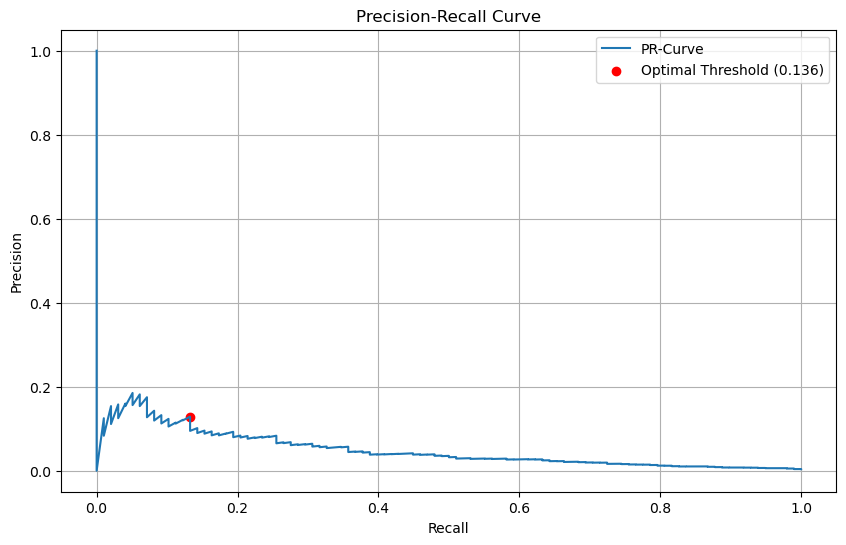


Не удалось найти порог с Precision > 70%


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    precision_recall_curve, confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

# === 1. Загрузка данных ===
data = pd.read_csv("TrainData.csv", sep=";")
X = data.drop("target", axis=1)
y = data["target"]

# Переименуем фичи для XGBoost (иначе могут быть ошибки с именами)
X.columns = [f"f{i}" for i in range(X.shape[1])]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Распределение классов в y_train до балансировки:")
print(y_train.value_counts())

# === 2. Уменьшаем класс 0 (undersampling) ===
X_train_majority = X_train[y_train == 0]
y_train_majority = y_train[y_train == 0]

X_train_minority = X_train[y_train == 1]
y_train_minority = y_train[y_train == 1]

# Соотношение 5:1 (ноликов в 5 раз больше чем единиц)
ratio = 100
X_train_majority_downsampled, y_train_majority_downsampled = resample(
    X_train_majority,
    y_train_majority,
    replace=False,
    n_samples=len(y_train_minority) * ratio,
    random_state=42
)

# Склеиваем обратно
X_train_balanced = pd.concat([X_train_majority_downsampled, X_train_minority])
y_train_balanced = pd.concat([y_train_majority_downsampled, y_train_minority])

print("\nРаспределение классов после undersampling:")
print(y_train_balanced.value_counts())

# === 3. Модели без дополнительных весов ===
base_models = [
    ("lr", LogisticRegression(max_iter=500, random_state=42)),
    
    ("rf", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )),
    
    ("xgb", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42,
        tree_method="auto"
    )),
    
    ("lgbm", LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )),
]

meta_model = LogisticRegression(max_iter=1000, random_state=42)

stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=3,
    n_jobs=-1
)

# === 4. Обучение ===
print("\nОбучение модели...")
stack_model.fit(X_train_balanced, y_train_balanced)

# === 5. Предсказание вероятностей ===
y_pred_proba = stack_model.predict_proba(X_test)[:, 1]

# === 6. Подбор оптимального порога ===
print("\n=== Подбор оптимального порога ===")
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Оптимальный порог по F1: {optimal_threshold:.4f}")
print(f"Precision: {precisions[optimal_idx]:.4f}")
print(f"Recall: {recalls[optimal_idx]:.4f}")
print(f"F1-Score: {f1_scores[optimal_idx]:.4f}")

y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# === 7. Метрики ===
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_optimal),
    "Precision": precision_score(y_test, y_pred_optimal),
    "Recall": recall_score(y_test, y_pred_optimal),
    "F1": f1_score(y_test, y_pred_optimal),
    "ROC-AUC": roc_auc_score(y_test, y_pred_proba)
}

print("\nМетрики стекинг-модели с оптимальным порогом:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# === 8. Матрица ошибок ===
print("\n=== Матрица ошибок ===")
cm = confusion_matrix(y_test, y_pred_optimal)
print("True Negatives:", cm[0, 0])
print("False Positives:", cm[0, 1])
print("False Negatives:", cm[1, 0])
print("True Positives:", cm[1, 1])

# === 9. PR-кривая ===
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, label='PR-Curve')
plt.scatter(recalls[optimal_idx], precisions[optimal_idx], c='red',
            label=f'Optimal Threshold ({optimal_threshold:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()




In [26]:
X.nunique()


f0     89734
f1     57903
f2     72096
f3     13053
f4     18049
       ...  
f68        2
f69        2
f70        2
f71        2
f72        2
Length: 73, dtype: int64

In [27]:
X.isnull().sum()


f0     0
f1     0
f2     0
f3     0
f4     0
      ..
f68    0
f69    0
f70    0
f71    0
f72    0
Length: 73, dtype: int64

In [32]:
corr = X.join(y).corr()['target'].sort_values()
print(corr)



f53      -0.032622
f7       -0.031325
f24      -0.030921
f0       -0.029216
f19      -0.028059
            ...   
f4        0.035469
f6        0.050106
f67       0.052100
f58       0.066235
target    1.000000
Name: target, Length: 74, dtype: float64


In [38]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_balanced, y_train_balanced)
importances = pd.Series(rf.feature_importances_, index=X_train_balanced.columns)
low_importance_features = importances[importances < 0.001].index.tolist()
print("Признаки с низкой важностью:", low_importance_features)


Признаки с низкой важностью: ['f34', 'f54', 'f55', 'f57', 'f60', 'f62', 'f63', 'f64', 'f65', 'f70']


In [39]:
nan_features = X_train_balanced.columns[X_train_balanced.isna().sum() > 0].tolist()
constant_features = X_train_balanced.columns[(X_train_balanced.nunique() / X_train_balanced.shape[0]) < 0.01].tolist()
print("Фичи с NaN:", nan_features)
print("Фиксированные признаки:", constant_features)


Фичи с NaN: []
Фиксированные признаки: ['f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72']
